# Big Data Analytics Project: Medical Appointment No Shows

Use the "Run" button to execute the code.

In [145]:
!pip install jovian --upgrade --quiet

In [146]:
import jovian

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Table of Contents

## Table of Contents
1. [Introduction](#intro) 
2. [Data Cleaning](#data_cleaning) 
3. [Feature Engineering](#feature_eng)
4. [Exploratory Analysis](#exploratory_analysis)
5. [Correlation Analysis](#correlations)
6. [Next Steps](#next_steps)

<a id='intro'></a>
# Introduction

The dataset used in this notebook is available at this [link](https://www.kaggle.com/joniarroba/noshowappointments).

Each record in the dataset rappresents a medical appointment that took place in Brazil. In particular, for each record is indicated if the patient showed up at the appointment or not. 

The objective of the analysis is to gain some insight regarding the factors that most influence whether a patient shows up for an appointment or not. 
In this way, it could be possible to predict with a good degree of accuracy whether or not a patient will show up for a given appointment, leading to less wasted resources, better services and reduced costs in the Brazilian healthcare system.

In [148]:
# import useful packages
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy as sp
import sklearn as sk
import matplotlib.pylab as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore")

In [149]:
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize

In [150]:
df = pd.read_csv("/content/drive/MyDrive/BigData/NoShowAppointments.csv")
df.sample(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
699,4.339387e+11,5640816,F,2016-04-29T11:27:58Z,2016-04-29T00:00:00Z,77,JESUS DE NAZARETH,0,1,1,0,0,0,No
95478,9.392136e+13,5742603,F,2016-05-30T08:09:36Z,2016-06-07T00:00:00Z,29,REDENÇÃO,0,0,0,0,0,1,No
102060,6.851264e+14,5720281,F,2016-05-19T13:36:19Z,2016-06-02T00:00:00Z,56,SANTO ANTÔNIO,0,1,1,0,0,1,No


Each record is composed by 14 attributes:

*   **PatientId**: identification of each patient.
*   **AppointmentID**: identification of each appointment.
*   **Gender**: male or Female.
*   **ScheduledDay**: the day of the booking of the appointment.
*   **AppointmentDay**: the day of the appointment, when they have to visit the doctor.
*   **Age**: how old is the patient.
*   **Neighbourhood**: where the appointment takes place.
*   **Scholarship**: True or False. If the patient is elegible to receive the government subsidy (*Bolsa familia*).
*   **Hipertension**: True or False. If the patient has hypertension or not.
*   **Diabetes**: True or False. If the patient has diabetes or not.
*   **Alcoholism**: True or False. If the patient has alcoholism or not.
*   **Handcap**: refers to the number of disabilites the patient has.
*   **SMS_received**: True or False. If the patient has received one or more SMS.
*   **No-show**: True or False. If the patient shows up to the appointment.



In [151]:
df.describe(include="all")

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
count,1.105270e+05,1.105270e+05,110527,110527,110527,110527.000000,110527,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527
unique,NaN,NaN,2,103549,27,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,NaN,JARDIM CAMBURI,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,NaN,NaN,71840,24,4692,NaN,7717,NaN,NaN,NaN,NaN,NaN,NaN,88208
mean,1.474963e+14,5.675305e+06,NaN,NaN,NaN,37.088874,NaN,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,NaN
std,2.560949e+14,7.129575e+04,NaN,NaN,NaN,23.110205,NaN,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,NaN
min,3.921784e+04,5.030230e+06,NaN,NaN,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,4.172614e+12,5.640286e+06,NaN,NaN,NaN,18.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,3.173184e+13,5.680573e+06,NaN,NaN,NaN,37.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,9.439172e+13,5.725524e+06,NaN,NaN,NaN,55.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The dataset contains 110527 records and there aren't any missing values.

In the following section we will analyse each attribute, perform some data cleaning and add new features in order to improve the overall quality of the dataset.

<a id='data_cleaning'></a>
# Data Cleaning

### Checking for duplicate records

We check if there are any duplicates.

In [153]:
print("Number of duplicate records: ", len(df[df.duplicated()]))

Number of duplicate records:  0


We check that all records have different a *AppointmentID*.

In [154]:
df.shape[0] == len(df["AppointmentID"].unique())

True

### *ScheduledDay* and *AppointmentDay*

First of all, we transform the attributes *ScheduledDay* and *AppointmentDay* in *datetime* objects so that it will be easier to work with them.

In [155]:
for col in ["ScheduledDay", "AppointmentDay"]:
  df[col] = pd.to_datetime(df[col])

In [156]:
df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
101929,1.738939e+13,5752283,F,2016-05-31 11:28:24+00:00,2016-06-02 00:00:00+00:00,6,JESUS DE NAZARETH,0,0,0,0,0,0,Yes
51346,2.471534e+11,5554819,F,2016-04-07 09:04:46+00:00,2016-05-05 00:00:00+00:00,22,MARIA ORTIZ,0,0,0,0,0,1,No
25880,3.379398e+13,5663865,M,2016-05-05 10:40:45+00:00,2016-05-16 00:00:00+00:00,16,ESTRELINHA,0,0,1,0,0,0,No
38307,9.146647e+12,5635752,M,2016-04-28 14:03:32+00:00,2016-05-25 00:00:00+00:00,44,SANTA TEREZA,0,0,0,0,0,1,No
81691,9.611967e+12,5672478,F,2016-05-09 08:06:38+00:00,2016-05-09 00:00:00+00:00,38,ITARARÉ,0,0,0,0,0,0,No


We note that, whereas in *ScheduledDay* are reported the exact date, hour, minutes and seconds of the reservation, in *AppointmentDay* only the day of the appointment is registered, since for every date the time is 00:00:00.

For this reason we decide to ignore and drop the time of the day in both attributes.


In [157]:
df["ScheduledDay"].dt.hour.unique()

array([18, 16, 17,  8, 15, 12, 14, 11, 10,  9,  7, 13, 19, 20,  6, 21])

In [158]:
df["AppointmentDay"].dt.hour.unique()

array([0])

In [159]:
for col in ["ScheduledDay", "AppointmentDay"]:
  df[col] = pd.to_datetime(df[col]).dt.date.astype('datetime64[ns]')

Let's figure out what is the time period covered by the records in the dataset.

In [160]:
df['ScheduledDay'].min()

Timestamp('2015-11-10 00:00:00')

In [161]:
df['ScheduledDay'].max()

Timestamp('2016-06-08 00:00:00')

The dataset contains appointment bookings covering a seven-month time span, ranging from the 10th of November 2015 through the 8th of June 2016.

In [162]:
df['AppointmentDay'].max()

Timestamp('2016-06-08 00:00:00')

In [163]:
df['AppointmentDay'].min()

Timestamp('2016-04-29 00:00:00')

The dataset contains appointments covering only a two-month time span, ranging from the 29th of April 2016 through the 8th of June 2016.

### *Age*

We check if there are any odd values for the *Age* attribute. 

In [164]:
df['Age'].value_counts().sort_index()

-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: Age, Length: 104, dtype: int64

In [165]:
# get the PatientId of the patient with age = -1
patientId = df[df['Age'] == -1]["PatientId"].values[0]
print("PatientId of patient with age=-1 is: " + str(patientId))

print("We have " + str(len(df[df["PatientId"] == patientId])) + " record with that PatientId")


PatientId of patient with age=-1 is: 465943158731293.0
We have 1 record with that PatientId


In [166]:
# Drop the record with Age = -1
df = df[df['Age'] != -1]

We note that there is only one record with negative patient's age. We check if there are other records with the same *PatientId* from which we could obtain the correct age, but there are none. Therfore we decide to delete this record.

The age of the patients range from 0 (we consider them newborns) to 115 years.

### *Neighbourhood*

We check if there are any odd values for the *Neighbourhood* attribute. 

In [167]:
df['Neighbourhood'].unique()

array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

In [168]:
len(df['Neighbourhood'].unique())

81

The appointments took place in 81 different neighborhoods. We leave this attribute as it is since there appears to be no irregularities.

### *Scholarship*

We check if there are any odd values for the *Scholarship* attribute. 

In [169]:
df['Scholarship'].value_counts().sort_index()

0    99665
1    10861
Name: Scholarship, dtype: int64

### *Hipertension*

We check if there are any odd values for the *Hipertension* attribute. 


In [170]:
df['Hipertension'].value_counts().sort_index()

0    88725
1    21801
Name: Hipertension, dtype: int64

### *Diabetes*

We check if there are any odd values for the *Diabetes* attribute. 


In [171]:
df['Diabetes'].value_counts().sort_index()

0    102583
1      7943
Name: Diabetes, dtype: int64

### *Alcoholism*

We check if there are any odd values for the *Alcoholism* attribute. 


In [172]:
df['Alcoholism'].value_counts().sort_index()

0    107166
1      3360
Name: Alcoholism, dtype: int64

### *Handcap*

We check if there are any odd values for the *Handcap* attribute. 


In [173]:
df['Handcap'].value_counts().sort_index()

0    108285
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

### *SMS_received*

We check if there are any odd values for the *SMS_received* attribute. 

In [174]:
df['SMS_received'].value_counts().sort_index()

0    75044
1    35482
Name: SMS_received, dtype: int64

### *No-show*

We check if there are any odd values for the *No-show* attribute. 

In [175]:
df['No-show'].value_counts().sort_index()

No     88207
Yes    22319
Name: No-show, dtype: int64

We change the values *Yes* and *No* with the integers 1 and 0 respectively. Also, we change the type of the attribute from string (object) to integer (int64).

In [176]:
df.loc[(df['No-show'] == "Yes"), 'No-show'] = 1
df.loc[(df['No-show'] == "No"), 'No-show'] = 0

In [177]:
df["No-show"] = df["No-show"].astype("int64")

### Rename attributes

We rename some attributes in order to correct some misspellings and assign more significant names, such as:

*   *ScheduledDay* is renamed *ScheduledDate*.
*   *AppointmentDay* is renamed *AppointmentDate*.
*   *Scholarship* is renamed *FinancialAid*.


In [178]:
df = df.rename(columns={'PatientId': 'PatientID', 
                        'Hipertension': 'Hypertension', 
                        'Handcap': 'Handicap', 
                        'No-show': 'No_show', 
                        'ScheduledDay': 'ScheduledDate', 
                        'AppointmentDay': 'AppointmentDate',
                        'Scholarship': 'FinancialAid'
                        })

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   PatientID        110526 non-null  float64       
 1   AppointmentID    110526 non-null  int64         
 2   Gender           110526 non-null  object        
 3   ScheduledDate    110526 non-null  datetime64[ns]
 4   AppointmentDate  110526 non-null  datetime64[ns]
 5   Age              110526 non-null  int64         
 6   Neighbourhood    110526 non-null  object        
 7   FinancialAid     110526 non-null  int64         
 8   Hypertension     110526 non-null  int64         
 9   Diabetes         110526 non-null  int64         
 10  Alcoholism       110526 non-null  int64         
 11  Handicap         110526 non-null  int64         
 12  SMS_received     110526 non-null  int64         
 13  No_show          110526 non-null  int64         
dtypes: datetime64[ns](2)

<a id='feature_eng'></a>
# Feature Engineering

In order to better explicitate information hidden in the original data we add the following new features:


*   **AppointmentDay**: the day of the week in which the appointment should take place.
*   **WaitingDays**: number of days between the day of the reservation and the actual day of the appointment.
*   **WaitingTime**: it categorizes the number of days the patient needs to wait into five categories: *Same Day*, *Short*, *Medium*, *High*, *Very High*.
*   **AgeGroup**: the age group of the patient (child, youth, adult, senior). 
*   **HasHandicap**: indicates whether the patient has some kind of handicap or not.






Also, for each record we add two new attributes that characterize the patient's history up to the current appointment:


*   **PrevAppointments**: total number of appointments preceding the current one.
*   **PrevNoShowRatio**: the no-show ratio up to the current appointment. We assign the value 0 to records referring to the first appointment of a patient.



### *AppointmentDay*

In [180]:
df['AppointmentDay'] = df['AppointmentDate'].dt.day_name()

In [181]:
df['AppointmentDay'] = pd.Categorical(df['AppointmentDay'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

### *WaitingDays*

In [182]:
df['WaitingDays'] = df['AppointmentDate'] - df['ScheduledDate']
df['WaitingDays'] = df['WaitingDays'].dt.days

We check if there are some records with negative *WaitingDays* value.

In [183]:
df[df['WaitingDays'] < 0]

,PatientID,AppointmentID,Gender,ScheduledDate,AppointmentDate,Age,Neighbourhood,FinancialAid,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay,WaitingDays
27033,7.839273e+12,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,1,Monday,-1
55226,7.896294e+12,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,Tuesday,-1
64175,2.425226e+13,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,1,Wednesday,-1
71533,9.982316e+14,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,Thursday,-6
72362,3.787482e+12,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,1,Tuesday,-1


There are only five records with negative *WaitingDays* value. We assume that the negative values come from some insertion errors of the attribute *AppointmentDate*. For this reason we decide to delete these records from the dataset.

In [184]:
df = df[df['WaitingDays'] >= 0]

### *WaitingTime*

We consider the following ranges to categorize the waiting days:


*   *Same Day*: the appointment is on the same day of the reservation.
*   *Short*: the number of waiting days is in the range \[1, 7\].
*   *Medium*: the number of waiting days is in the range \[8, 15\].
*   *High*: the number of waiting days is in the range \[16, 30\].
*   *Very High*: the number of waiting days is greater than or equal to 31.



In [185]:
def get_waiting_time(days):
  if days == 0:
    return "Same Day"
  if 1 <= days <= 7:
    return "Short"
  if 8 <= days <= 15:
    return "Medium"
  if 16 <= days <= 30:
    return "High"
  if days >= 31:
    return "Very High"

In [186]:
df['WaitingTime'] = df['WaitingDays'].apply(get_waiting_time)


In [187]:
df['WaitingTime'] = pd.Categorical(df['WaitingTime'], ["Same Day", "Short", "Medium", "High", "Very High"])

### *AgeGroup*

We consider the following ranges to categorize the age groups:


*   *Child*: the age of the patient is less than or equal to 14 years.
*   *Youth*: the age of the patient is in the range \[15, 24\] years.
*   *Adult*: the age of the patient is in the range \[25, 64\] years.
*   *Senior*: the age of the patient is greater than or equal to 65 years.

In [188]:
def get_age_group(age):
  if age <= 14:
    return "Child"
  elif age < 25:
    return "Youth"
  elif age < 65:
    return "Adult"
  else:
    return "Senior"

In [189]:
df['AgeGroup'] = df['Age'].apply(get_age_group)
df['AgeGroup'] = pd.Categorical(df['AgeGroup'], ["Child", "Youth", "Adult", "Senior"])

### *HasHandicap*

In [190]:
def has_handicap(handicap_count):
  if handicap_count > 0:
    return 1
  else:
    return 0

In [191]:
df['HasHandicap'] = df['Handicap'].apply(has_handicap)

### Patient's history related attributes

In [192]:
df.sort_values(["PatientID","AppointmentDate"], inplace=True)

prev_no_show = []
prev_appointments = []

previous_patient = None

number_of_prev_app = 0
number_of_prev_no_show = 0

for index, row in df.iterrows():
  current_patient = row['PatientID']
  if current_patient != previous_patient:
    prev_no_show.append(0)
    prev_appointments.append(0)
    # Assigning variables for the next iteration
    number_of_prev_app = 1
    if row['No_show'] == 1:
      number_of_prev_no_show = 1
    else:
      number_of_prev_no_show = 0
    previous_patient = current_patient
  else:
    prev_no_show.append(number_of_prev_no_show)
    prev_appointments.append(number_of_prev_app)
    if row['No_show'] == 1:
      number_of_prev_no_show += 1
    number_of_prev_app += 1

df['PrevAppointments'] = prev_appointments
df['PrevNoShow'] = prev_no_show
df['PrevNoShowRatio'] = df[df['PrevAppointments'] > 0]['PrevNoShow'] / df[df['PrevAppointments'] > 0]['PrevAppointments']

df.drop(['PrevNoShow'], axis=1, inplace=True)

df['PrevNoShowRatio'].fillna(value=0, inplace=True)

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 100517 to 76224
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   PatientID         110521 non-null  float64       
 1   AppointmentID     110521 non-null  int64         
 2   Gender            110521 non-null  object        
 3   ScheduledDate     110521 non-null  datetime64[ns]
 4   AppointmentDate   110521 non-null  datetime64[ns]
 5   Age               110521 non-null  int64         
 6   Neighbourhood     110521 non-null  object        
 7   FinancialAid      110521 non-null  int64         
 8   Hypertension      110521 non-null  int64         
 9   Diabetes          110521 non-null  int64         
 10  Alcoholism        110521 non-null  int64         
 11  Handicap          110521 non-null  int64         
 12  SMS_received      110521 non-null  int64         
 13  No_show           110521 non-null  int64         
 14  

In [194]:
df.sample(5)

,PatientID,AppointmentID,Gender,ScheduledDate,AppointmentDate,Age,Neighbourhood,FinancialAid,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay,WaitingDays,WaitingTime,AgeGroup,HasHandicap,PrevAppointments,PrevNoShowRatio
41424,9.656834e+14,5737521,F,2016-05-25,2016-05-31,32,JABOUR,1,1,0,0,0,1,0,Tuesday,6,Short,Adult,0,2,0.0
65410,8.993716e+13,5532963,M,2016-03-31,2016-05-16,2,JARDIM CAMBURI,0,0,0,0,0,0,1,Monday,46,Very High,Child,0,0,0.0
65763,6.821990e+13,5521103,F,2016-03-29,2016-05-30,6,JARDIM CAMBURI,0,0,0,0,0,1,1,Monday,62,Very High,Child,0,0,0.0
54319,9.411232e+11,5682928,M,2016-05-11,2016-05-19,18,ILHA DO PRÍNCIPE,1,0,0,0,0,0,0,Thursday,8,Medium,Youth,0,2,0.5
71149,7.797755e+12,5655806,F,2016-05-04,2016-05-04,0,FONTE GRANDE,0,0,0,0,0,0,0,Wednesday,0,Same Day,Child,0,1,0.0


<a id='exploratory_analysis'></a>
# Exploratory Analysis

### *No-Show*

First of all, we visualize the percentage of show and no-show appointments.

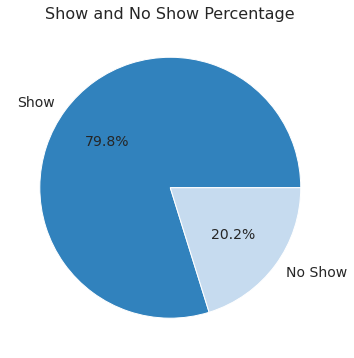

In [195]:
# Ratio between show and no-show appointments
fig = plt.figure(figsize =(8, 6))

blues = ["#3182BD","#C6DBEF"]
my_labels = ["Show", "No Show"]
plt.title('Show and No Show Percentage', fontsize=16)
plt.pie(df['No_show'].value_counts(), labels=my_labels, autopct='%1.1f%%', colors=blues, textprops={'fontsize': 14})
plt.show()

The dataset is unbalanced. This fact is expected since the majority of people that book a medical examination will show up to the appointment.

### *Age*

We analyse the distribution of the attribute *Age* to see if there are any outliers, then we visualize the percentage of appointments for each age group.

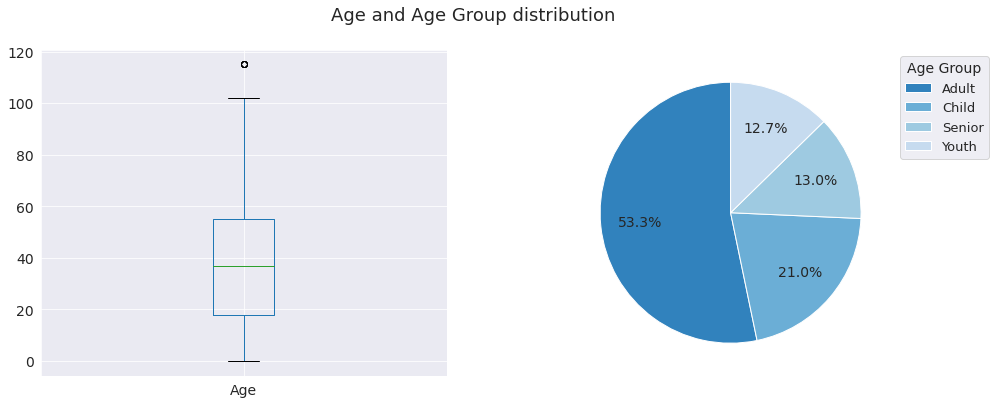

In [196]:
fig = plt.figure(figsize =(16, 6))
fig.suptitle('Age and Age Group distribution', fontsize=18)


plt.subplot(1, 2, 1)
df['Age'].plot.box(fontsize=14)

plt.subplot(1, 2, 2)
blues = ["#3182BD","#6BAED6","#9ECAE1","#C6DBEF"]
my_labels = ["Adult", "Child", "Senior", "Youth"]

plt.pie(df['AgeGroup'].value_counts(), autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7, startangle=90)
plt.legend(title="Age Group", title_fontsize=14, labels=my_labels, bbox_to_anchor=(1, 1))#bbox_to_anchor=(1, 0.6)
plt.show()

The box plot shows one outlier value (115) for the *Age* attribute. As seen before, only 5 records have the *Age* attribute equal to 115, since these records seem to be legitimate we decide to keep them.

In addition, we note that most appointments are booked by adults, followed by children and, almost equally, by seniors and youth.

### *Neighbourhood*

In [ ]:
df['Neighbourhood'].value_counts().plot(kind='bar', figsize =(20, 6), linewidth=0, xlabel="Neighbourhood")
plt.title("Number of Appointments per Neighbourhood", fontsize=18)
plt.show()

We note that the distribution of the appointments in the different neighbourhoods is not uniform: there are few neighbourhoods where the majority of the appointments took place.

### *AppointmentDay*

In [ ]:
plt.title("Number of Appointments per Day of the Week", fontsize=16)
df['AppointmentDay'].value_counts(sort=False).plot(kind='bar', figsize =(15, 6), linewidth=0, xlabel="Day of the Week")
plt.show()

We note that the majority of the appointments took place between Monday and Friday, only a handful of appointments took place on Saturday and none took place on Sunday.

### *WaitingDays* and *WaitingTime*

In [ ]:
fig = plt.figure(figsize =(20, 12))

my_labels = ["Same Day", "Short", "Medium", "High", "Very High"]
blues = ["#DAE8F5", "#88BEDC","#539DCC","#2A7AB9","#0B559F"]
plt.subplot(1,3,2)
plt.title("Waiting Time Distribution", fontsize=18)
plt.pie(df['WaitingTime'].value_counts(), autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)
plt.legend(title="Waiting Time", title_fontsize=14, labels=my_labels, bbox_to_anchor=(1, 0.9))

fig = plt.figure(figsize =(20, 6))
fig.suptitle("Waiting Days Distribution", fontsize=18)
plt.subplot(1,2,1)

df['WaitingDays'].plot.hist(bins=36, xlabel="Waiting Days")

plt.subplot(1,2,2)
#plt.title("Box Plot", fontsize=16)
df['WaitingDays'].plot.box()
plt.show()




We note that most of the appointments took place within 7 days from the booking date. Moreover, almost 35% of the appointments took place the same day of the booking. Indeed, the values of the attribute *WaitingDays* follow a very skewed distribution. 

Furthermore, as we can see from the box plot, the values belonging to the categories *High* and *Very High* are considered outliers, however, since they add up to 20% of the records of the dataset, we decide to keep them.

### *PrevAppointments* and *PrevNoShowRatio*

In [ ]:
fig = plt.figure(figsize =(20, 6))
fig.suptitle("PrevAppointments and PrevNoShowRatio Distribution", fontsize=18)
plt.subplot(1,2,1)
plt.xlabel("Previous Appointments")
df['PrevAppointments'].plot.hist(bins=44)

plt.subplot(1,2,2)
#plt.title("Box Plot", fontsize=16)
plt.xlabel(" Previous Appointments No-Show Ratio")
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
df['PrevNoShowRatio'].plot.hist()
plt.show()


We note that both attributes follow a very skewed distribution. This is mainly due to the fact that the majority of the records refers to the first appointment of a patient. 

We now observe how many patients have booked a certain number of appointments:

In [ ]:
print("Total number of patients: ", len(df['PatientID'].unique()), end="\n\n")

# count how many patients have done x appointments (x appointments ---> number of patients)
s = df.groupby(by=['PatientID']).size().value_counts().sort_index()

tmp = pd.DataFrame({'#Appointments':s.index, '#Patients':s.values})
tmp.style.hide_index()

We observe that about 60\% of patients made only one appointment. However, we think it still might be helpful to know the no-show rate for patients who have made more than one appointment. Therefore, we think these two attributes might be helpful during the classification phase.

### Distributions of the other attributes

In [ ]:
fig = plt.figure(figsize =(24, 6))#, tight_layout=True)

blues = ["#3182BD","#C6DBEF"]

plt.subplot(1, 3, 1)
my_labels = ["Female", "Male"]
plt.title("Gender Distribution", fontsize=16)
plt.pie(df['Gender'].value_counts(), labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)

plt.subplot(1, 3, 2)
my_labels = ["No Financial Aid", "Financial Aid"]
plt.title("Financial Aid Distribution", fontsize=16)
plt.pie(df['FinancialAid'].value_counts(), labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)

plt.subplot(1, 3, 3)  
my_labels = ["No handicap", "Handicap"]
plt.title("Handicap Distribution", fontsize=16)
plt.pie(df['HasHandicap'].value_counts(), labels=my_labels, autopct='%1.0f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.72)
plt.show()

We note that the dataset is unbalanced with respect to the *Gender* attribute and even more unbalanced with respect to the *HasHandicap* and *FinancialAid* attributes.

In [ ]:
fig = plt.figure(figsize =(24, 6))
fig.suptitle("Disease Attributes Distribution", fontsize=18)

plt.subplot(1, 3, 1)
my_labels = ["No Hypertension", "Hypertension"]
plt.pie(df['Hypertension'].value_counts(), labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)

plt.subplot(1, 3, 2)
my_labels = ["No Diabetes", "Diabetes"]
plt.pie(df['Diabetes'].value_counts(), labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)

plt.subplot(1, 3, 3)  
my_labels = ["No Alcoholism", "Alcoholism"]
plt.pie(df['Alcoholism'].value_counts(), labels=my_labels, autopct='%1.0f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.72)
plt.show()

The dataset is very unbalanced with respect to the *Hypertension*, *Diabetes*, *Alcoholism* attributes.

In [ ]:
# SMS_received           
my_labels = ["No SMS Received", "SMS Received"]
fig = plt.figure(figsize =(8, 6))

plt.title("SMS Distribution", fontsize=16)
plt.pie(df['SMS_received'].value_counts(), labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=blues, pctdistance=.7)
plt.show()

Nearly two-thirds of patients did not receive a SMS for a specific appointment.

### *No_show* ratio for different attributes

In this section we investigate whether the value of certain attributes affects the likelihood that a patient will or will not show up for an appointment.

In particular, for each attribute we visualise the no-show ratio for all the possible values of that attribute.

In [ ]:
#No show ratio for different attributes function def
def no_show_ratio(tmp_df, columns):
  return tmp_df[tmp_df["No_show"] == 1].groupby([columns]).size()/tmp_df.groupby([columns]).size()
  

In [ ]:
fig = plt.figure(figsize=(16,12))
fig.suptitle("No Show Ratios", fontsize=18)

plt.subplot(2,2,1)
male_female_ratio = no_show_ratio(df, "Gender")
male_female_ratio.plot(kind='bar')

plt.subplot(2,2,2)
handicap_ratio = no_show_ratio(df, "HasHandicap")
handicap_ratio.plot(kind='bar')

plt.subplot(2,2,3)
appointment_day_ratio = no_show_ratio(df, "AppointmentDay")
appointment_day_ratio.plot(kind='bar')

plt.subplot(2,2,4)
financial_aid_ratio = no_show_ratio(df, "FinancialAid")
financial_aid_ratio.plot(kind='bar')
plt.show()

It seems that whether a patient is male or female, or whether the patient has a disability or not, does not affect the fact that the patient shows up for the appointment or not.

Regarding the *AppointmentDay* and *FinancialAid* attributes, we note a slight difference in the no_show ratio depending on the value of the attribute. Nevertheless, we believe these differences are not very significant.

In [ ]:
fig = plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title("No show Ratio for Age Group", fontsize=16)
age_group_ratio = no_show_ratio(df, "AgeGroup")
age_group_ratio.plot(kind='bar')

plt.subplot(1,2,2)
plt.title("No show Ratio for Waiting Time", fontsize=16)
waiting_time_ratio = no_show_ratio(df, "WaitingTime")
waiting_time_ratio.plot(kind='bar')
plt.show()

We note that the no-show ratio is higher for youths and lower for seniors. This is reasonable taking into account the fact that older people tend to have more health related problems with respect to youger ones, therefore seniors usually do not miss medical appointments. 

However, we have an almost identical no-show ratio for children and adults. This may be explained by the fact that adults are in charge of their children's appointments.

Regarding the *WaitingTime* attribute, we observe a really small no-show ratio for the appointments scheduled on the same day of the booking. For the others *WaitingTime* categories we have a larger no-show ratio. Moreover, the no-show ratio increases as the waiting time grows.

In [ ]:
rows = []

for column in ['Diabetes', 'Alcoholism', 'Hypertension']:
  for value in sorted(df[column].unique()):
    row = {'Disease' : column}
    total = len(df[df[column] == value])
    n = len(df[(df['No_show'] == 1) & (df[column] == value)])
    row.update({'Has Disease': value, 'No Show Probability': n/total})
    rows.append(row)

blues = ["#3182BD","#C6DBEF"]
pd.DataFrame(rows).pivot("Disease", "Has Disease", "No Show Probability").plot(kind='bar', width=.5, edgecolor='white', linewidth=1, figsize =(9, 6), rot=0, color=blues)
plt.title("No show Ratio for different diseases", fontsize=16)
plt.legend(title="Has Disease", title_fontsize=13, bbox_to_anchor=(1.21, 1))
plt.show()

We note that the likelihood of showing up for appointments is slightly higher for patients with diabetes and hypertension.

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.title("No show Ratio for SMS received", fontsize=16)
SMS_received_ratio = no_show_ratio(df, "SMS_received")
SMS_received_ratio.plot(kind='bar')
plt.show()

We note that receiving the text message seems to negatively affect whether a patient shows up for the appointment. 

This seems counterintuitive, as receiving the text message may be expected to remind people to go to the appointment. However, we do not know when text messages are sent to patients, making it more difficult to discuss their effectiveness. 

For example, if the text message is sent only a few hours before the appointment to a patient who booked the appointment long before, the patient may have forgotten about the appointment before receiving the text message and therefore may not show up because they now have other commitments.

We can investigate whether receiving the text message is more effective for certain age groups. For example, one could think that young people are more confident with smartphone use than older people.

In [ ]:
blues = ["#3182BD","#C6DBEF"]

#Se invertiamo l'ordine di raggruppamento sull'asse x otteniamo un'altra versione
df_ratio = (df[df["No_show"] == 1].groupby(["AgeGroup", "SMS_received"] ).size()/df.groupby(["AgeGroup", "SMS_received"]).size()).unstack()
df_ratio.plot(kind='bar', color=blues, figsize=(9,6))
plt.legend(title="SMS received", title_fontsize=14)#, bbox_to_anchor=(1, 1))
plt.show()

However, receiving the text message turns out to have a negative impact in all age groups.

We now investigate whether the effectiveness of the text message changes for longer or shorter waiting times.

In [ ]:
df_ratio = (df[df["No_show"] == 1].groupby(["WaitingTime", "SMS_received"] ).size()/df.groupby(["WaitingTime", "SMS_received"]).size()).unstack()
df_ratio.plot(kind='bar', color=blues, figsize=(9,6))
plt.legend(title="SMS received", title_fontsize=14)#, bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
print("Number of records with 'WaitingTime' = 'Same Day' and 'SMS_received' = 1:", len(df[(df['WaitingTime'] == 'Same Day') & (df['SMS_received'] == 1)]))

The effectiveness of receiving the text message seems to increase as the appointment waiting time grows.

<a id='correlations'></a>
# Correlation Analysis

In [ ]:
columns = df.columns.drop(['PatientID', 'AppointmentID'])

corr = df[columns].corr()
plt.subplots(figsize =(13, 11))
hm = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

As expected there is a large correlation between the attributes *Handicap* and *HasHandicap*, since the latter is directly computed from the former.

There is a slight correlation between the attribute *Age* and the attributes *Hypertension* and *Diabetes*. This is reasonable as these diseases affect older people more. Also, *Hypertension* and *Diabetes* are slightly correlated with each other.

Moreover, we note a slight correlation between the attributes *WaitingDays* and *SMS_received*.

Finally, we observe that the attributes that have a higher correlation (albeit minimal) with the No-show attribute are *WaitingDays (0.19)*, *SMS_Received* (0.13) and *PrevNoShowRatio* (0.11).


<a id='next_steps'></a>
# Next steps

The next part of the analysis will focus on creating a predictive model for the target variable *No-show*. To do this, we should select a subset of meaningful attributes and normalize them if necessary.

Our goal is to select a model that is fairly accurate in prediction and at the same time has good explainability. It is important that the model is interpretable enough as this can help to understand what the main reasons are for a patient not showing up for an appointment, allowing to improve service quality and reduce costs.

In [ ]:
df.to_csv("/content/drive/MyDrive/BigData/NoShowAppointments-part2.csv", index=False)

# Save the Notebook

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="bda-project-part-1")